#### Machine Learing Project to find XXXXXX Nov-16-2018

In [159]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(7)

In [123]:
dataset = pd.read_csv("/Users/cmallavarapu/Documents/Chiran/MSDS/ML/train_sample.csv")

In [127]:
dataset.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [153]:
len(dataset)

100000

In [129]:
dataset['click_time'] = pd.to_datetime(dataset['click_time'])

In [152]:
dataset.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0
7,121505,9,1,25,442,2017-11-07 10:01:53,NaN,0
8,192967,2,2,22,364,2017-11-08 09:35:17,NaN,0
9,143636,3,1,19,135,2017-11-08 12:35:26,NaN,0


In [154]:
import seaborn as sns
sns.set(style="ticks")

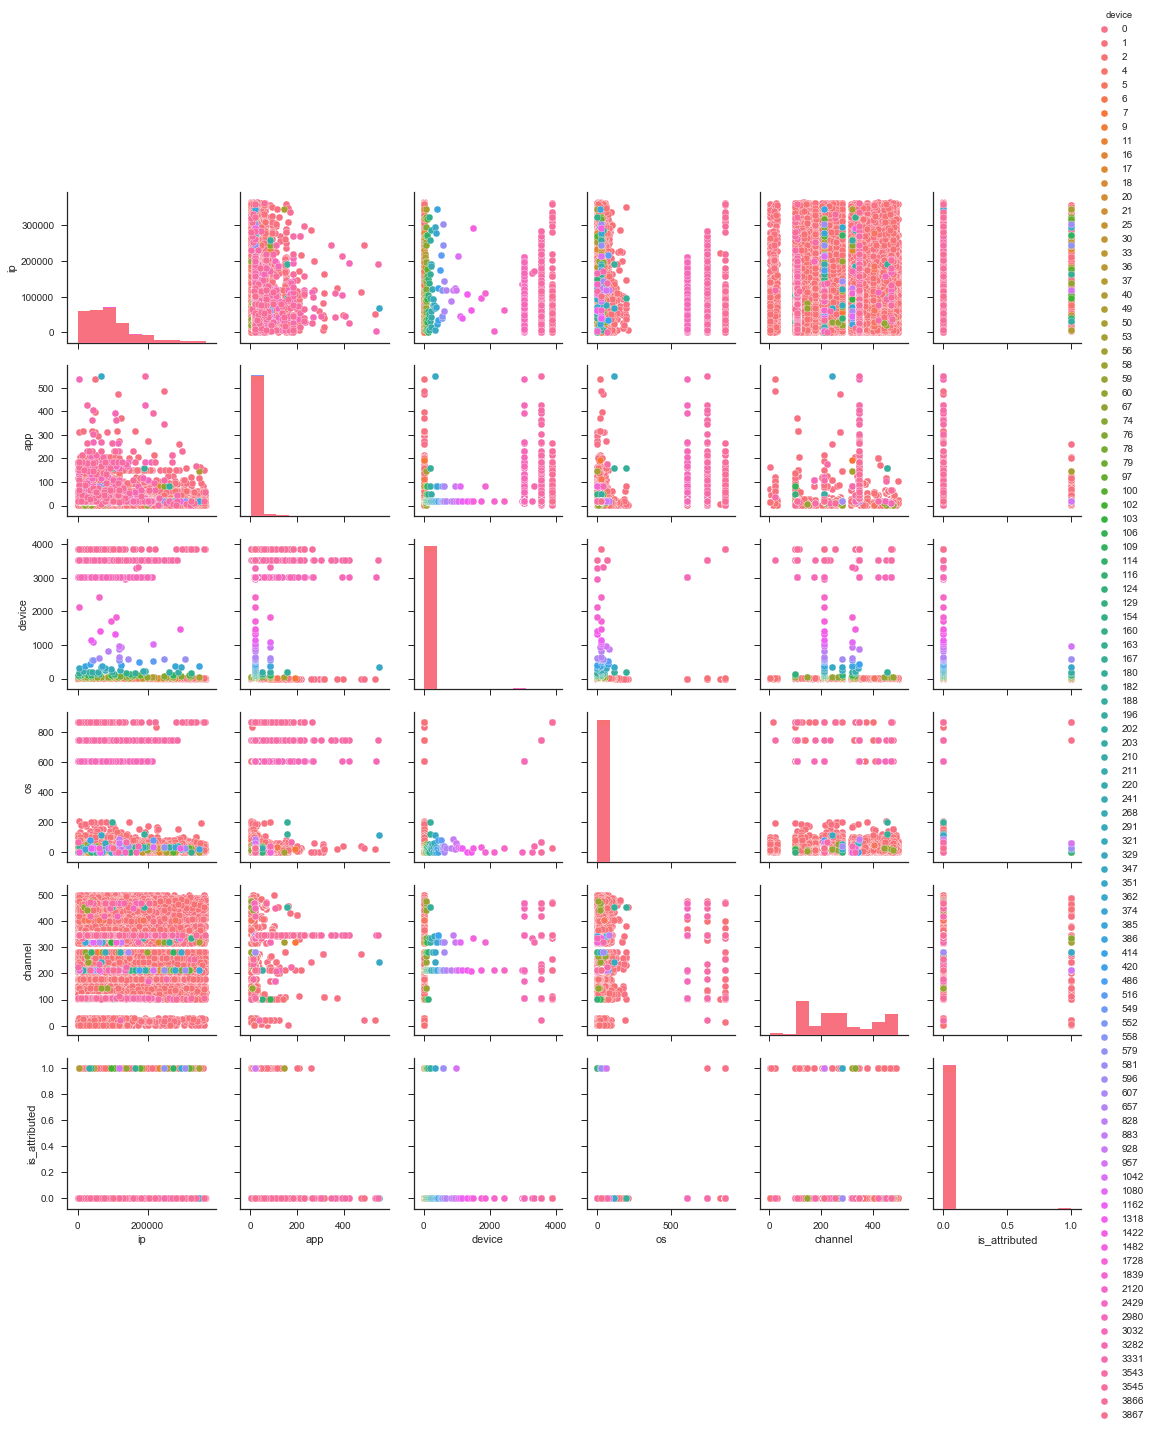

In [155]:
sns.pairplot(dataset, hue="device")

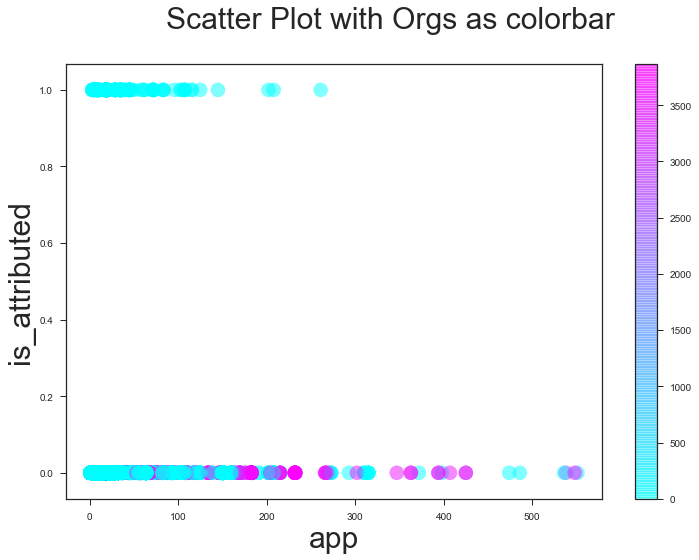

In [162]:
np.random.seed(19680801)
fig = plt.figure(figsize=(12,8))

N = 50
#colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

colors = dataset['device']

# c=colors,
scatter=plt.scatter(dataset['app'], dataset['is_attributed'], s=200,alpha=0.5, c = colors,cmap='cool')
fig.suptitle('Scatter Plot with Orgs as colorbar', fontsize=30)
plt.xlabel('app', fontsize=30)
plt.ylabel('is_attributed', fontsize=30)


plt.colorbar(scatter)
plt.show()

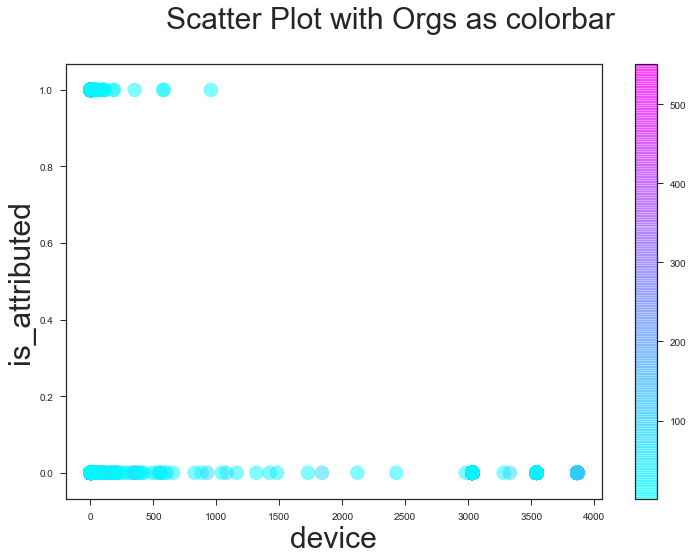

In [164]:
np.random.seed(19680801)
fig = plt.figure(figsize=(12,8))

N = 50
#colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

colors = dataset['app']

# c=colors,
scatter=plt.scatter(dataset['device'], dataset['is_attributed'], s=200,alpha=0.5, c = colors,cmap='cool')
fig.suptitle('Scatter Plot with Orgs as colorbar', fontsize=30)
plt.xlabel('device', fontsize=30)
plt.ylabel('is_attributed', fontsize=30)


plt.colorbar(scatter)
plt.show()

#### Lets model the data using Neural Networks

In [131]:
X = np.array(dataset)[:,0:5]
Y = np.array(dataset)[:,7]

In [132]:
X[0:4]

array([[87540, 12, 1, 13, 497],
       [105560, 25, 1, 17, 259],
       [101424, 12, 1, 19, 212],
       [94584, 13, 1, 13, 477]], dtype=object)

In [134]:
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=100, batch_size=10000)
scores = model.evaluate(X, Y)
print("hi", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/100
100000/100000 [==============================] - 1s 8us/step - loss: 11.5649 - acc: 0.2365
Epoch 2/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0393 - acc: 0.9971
Epoch 3/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0379 - acc: 0.9974
Epoch 4/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0373 - acc: 0.9975
Epoch 5/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0369 - acc: 0.9976
Epoch 6/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0367 - acc: 0.9977
Epoch 7/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 8/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 9/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 10/100
100000/100000 [==============================] - 0s 1us/step - loss:

100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 81/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 82/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 83/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 84/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 85/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 86/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 87/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 88/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.0366 - acc: 0.9977
Epoch 89/100
100000/100000 [==============================] - 0s 1us/step - loss: 0.03

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [137]:
X_train.shape[1:]

(5,)

In [138]:
import string
import random
import numpy as np

from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, SpatialDropout1D, Conv1D,Conv2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D

In [148]:
# Standard off the shelf 
def create_model(i_shape):
    #refactored to allow for num_labels
    model = Sequential()
    model.add(Conv1D(64, 2, input_shape=i_shape,padding='same'))
    model.add(Dense(12, input_dim=6, activation='relu'))
    model.add(SpatialDropout1D(0.2))
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 5, padding='same', activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D())
    #model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    loss = 'binary_crossentropy'
    model.compile(loss=loss, optimizer= 'adam', metrics=['accuracy'])
    model.summary()
    return model

In [116]:
X_train.shape

(80000, 5, 1)

In [142]:
X_train = X_train.reshape(-1, 5, 1)
X_test= X_test.reshape(-1, 5, 1)

In [118]:
X_train.shape

(80000, 5, 1)

In [119]:
X_test.shape

(20000, 5, 1)

In [120]:
Y_train[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [149]:
# construct the model
clf = create_model(X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 5, 64)             192       
_________________________________________________________________
dense_64 (Dense)             (None, 5, 12)             780       
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 5, 12)             0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 5, 12)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 5, 64)             3904      
_________________________________________________________________
dropout_47 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 2, 64)             0         
__________

In [150]:
clf.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=10000)

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 2s 30us/step - loss: 8.4828 - acc: 0.4658 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 2/100
80000/80000 [==============================] - 1s 16us/step - loss: 1.0352 - acc: 0.9344 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 3/100
80000/80000 [==============================] - 1s 16us/step - loss: 0.1165 - acc: 0.9926 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 4/100
80000/80000 [==============================] - 1s 15us/step - loss: 0.0479 - acc: 0.9969 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 5/100
80000/80000 [==============================] - 1s 16us/step - loss: 0.0428 - acc: 0.9973 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 6/100
80000/80000 [==============================] - 1s 16us/step - loss: 0.0388 - acc: 0.9976 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 7/100
80000/80000 [==============================] - 1s 15us/step - loss: 0.0384 - acc: 0.9976 - val_loss: 0.0411 - 

80000/80000 [==============================] - 1s 16us/step - loss: 0.0363 - acc: 0.9977 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 60/100
80000/80000 [==============================] - 1s 16us/step - loss: 0.0365 - acc: 0.9977 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 61/100
80000/80000 [==============================] - 1s 18us/step - loss: 0.0368 - acc: 0.9977 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 62/100
80000/80000 [==============================] - 1s 17us/step - loss: 0.0363 - acc: 0.9977 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 63/100
80000/80000 [==============================] - 1s 17us/step - loss: 0.0367 - acc: 0.9977 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 64/100
80000/80000 [==============================] - 2s 30us/step - loss: 0.0363 - acc: 0.9978 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 65/100
80000/80000 [==============================] - 1s 15us/step - loss: 0.0365 - acc: 0.9977 - val_loss: 0.0411 - val_acc: 0.9974
Epoch 66/100
80000/80000 [==============

In [151]:
print ("hi")

hi
